# 601 Figure 1

In this notebook, we use an illustrative scenario to show our analytical approach (Figure 1 in the main paper).

In [1]:
import pyam
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from pathlib import Path

<IPython.core.display.Javascript object>

Step 1: Decide which scenario we want to use for illustrative purposes.

In [2]:
mod_scen = [('REMIND-MAgPIE 2.1-4.3', 'DeepElec_SSP2_ HighRE_Budg900')]

Step 2: Read in the novel CDR (original) as well as the novel CDR (adapted). For the latter, we want to process the data to get the levels at the following percentiles:
* p33, p50, p67, p90

In [3]:
novel_cdr = pd.read_csv(
    Path(
        '../data/100_novel_cdr.csv'
    ),
    index_col=[0, 1]
)

In [4]:
novel_cdr_ill = pyam.IamDataFrame(
    novel_cdr.loc[mod_scen, :]
    .reset_index()
)

In [5]:
novel_cdr_clim = pd.read_csv(
    Path(
        '../data/405_cdr_170324.csv'
    ),
    index_col=[0, 1] 
)

In [6]:
novel_cdr_clim_ill = (
    novel_cdr_clim.loc[mod_scen, :]
    .drop(columns='Angle')
    .set_index(['Region', 'Variable', 'Unit', 'Ensemble_Member'], append=True)
)

In [7]:
pd.DataFrame(novel_cdr_clim_ill.quantile(q=0.5)).reset_index()

,index,0.5
0,2000,NaN
1,2005,2.617100
2,2010,2.899600
3,2015,3.182800
4,2016,3.246020
...,...,...
84,2096,2570.561281
85,2097,2557.986211
86,2098,2545.411141
87,2099,2532.836071


In [8]:
novel_clim_ill_quantiles = []
for quant in [0.33, 0.5, 0.67, 0.9]:
    novel_to_process = pyam.IamDataFrame(
        pd.DataFrame(novel_cdr_clim_ill.quantile(q=quant))
        .reset_index()
        .rename(
            columns={
                quant: 'value',
                'index': 'year'
            }
        )
        .assign(
            model='REMIND-MAgPIE 2.1-4.3',
            scenario='DeepElec_SSP2_ HighRE_Budg900',
            region='World',
            variable=f'Carbon Dioxide Removal|Novel [p{int(quant*100)}]',
            unit='Mt CO2/yr'
        )
    )
    novel_clim_ill_quantiles.append(novel_to_process)

In [9]:
novel_clim_ill_quantiles = pyam.concat(novel_clim_ill_quantiles)

Step 3: Read in the emissions from the original scenario.

In [10]:
emissions = pd.read_csv(
    Path(
        '../data/100_scenarios.csv'
    ),
    index_col=[0,1]
)

In [11]:
emissions_ill = pyam.IamDataFrame(
    emissions.loc[mod_scen, :]
)

In [12]:
emissions_ill.filter(
    variable='AR6 climate diagnostics|Infilled|Emissions|CO2',
    inplace=True
)

In [13]:
emissions_ill.swap_time_for_year(inplace=True)

Step 4: Now, we want to read in the original and processed warming dataframes and crunch the respective quantiles for each of these datasets.

In [14]:
original_warming = pd.read_csv(
    Path(
        '../data/201_original_all_ghg_temps.csv'
    ),
    index_col=[1,6]
)

In [15]:
original_warming_ill = (
    original_warming.loc[mod_scen, :]
    .set_index(
        [
            'climate_model',
            'reference_period_end_year',
            'reference_period_start_year',
            'region',
            'run_id',
            'unit',
            'variable'
        ]
    )
)

In [16]:
original_warming_ill.columns = [x.split('-')[0] for x in original_warming_ill.columns]

In [17]:
original_temp_quantiles = []
for quant in [0.33, 0.5, 0.67, 0.9]:
    temp_to_process = pyam.IamDataFrame(
        pd.DataFrame(original_warming_ill.quantile(q=quant))
        .reset_index()
        .rename(
            columns={
                quant: 'value',
                'index': 'year'
            }
        )
        .assign(
            model='REMIND-MAgPIE 2.1-4.3',
            scenario='DeepElec_SSP2_ HighRE_Budg900',
            region='World',
            variable=f'Surface Air Temperature Change [p{int(quant*100)}]',
            unit='K'
        )
    )
    original_temp_quantiles.append(temp_to_process)

In [18]:
original_temp_quantiles = pyam.concat(original_temp_quantiles)

In [19]:
proc_warming = pd.read_csv(
    Path(
        '../data/405_temp_170324.csv'
    ),
    index_col=[0,1]
)

In [20]:
proc_warming_ill = (
    proc_warming.loc[mod_scen, :]
    .set_index(
        [
            'Climate_Model',
            'Reference_Period_End_Year',
            'Reference_Period_Start_Year',
            'Region',
            'Run_Id',
            'Unit',
            'Variable',
            'Ensemble_Member'
        ]
    )
)

In [21]:
proc_warming_ill.columns = [x.split('-')[0] for x in proc_warming_ill.columns]

In [22]:
proc_temp_quantiles = []
for quant in [0.33, 0.5, 0.67, 0.9]:
    temp_to_process = pyam.IamDataFrame(
        pd.DataFrame(proc_warming_ill.quantile(q=quant))
        .reset_index()
        .rename(
            columns={
                quant: 'value',
                'index': 'year'
            }
        )
        .assign(
            model='REMIND-MAgPIE 2.1-4.3',
            scenario='DeepElec_SSP2_ HighRE_Budg900',
            region='World',
            variable=f'Surface Air Temperature Change [p{int(quant*100)}]',
            unit='K'
        )
    )
    proc_temp_quantiles.append(temp_to_process)

In [23]:
proc_temp_quantiles = pyam.concat(proc_temp_quantiles)

Step 5: Calculate the new CO2 emissions trajectories.

In [24]:
compiled_emissions = pyam.concat(
    [emissions_ill, novel_clim_ill_quantiles, novel_cdr_ill]
)

In [25]:
compiled_emissions.filter(
    year=range(2020, 2101),
    inplace=True
)

In [26]:
compiled_emissions.interpolate(
    time=range(2020, 2101),
    inplace=True
)

In [27]:
compiled_emissions.convert_unit(
    current='Mt CO2/yr',
    to='Gt CO2/yr',
    inplace=True
)

In [28]:
for q in ['p33', 'p50', 'p67', 'p90']:
    compiled_emissions.subtract(
        a=f'Carbon Dioxide Removal|Novel [{q}]',
        b='Carbon Dioxide Removal|Novel',
        ignore_units='Gt CO2/yr',
        name=f'Carbon Dioxide Removal|Novel|Additional [{q}]',
        append=True
    )
    compiled_emissions.subtract(
        a='AR6 climate diagnostics|Infilled|Emissions|CO2',
        b=f'Carbon Dioxide Removal|Novel|Additional [{q}]',
        ignore_units='Gt CO2/yr',
        name=f'AR6 climate diagnostics|Infilled|Emissions|CO2 [{q}]',
        append=True
    )

Step 7: Let us plot this out.

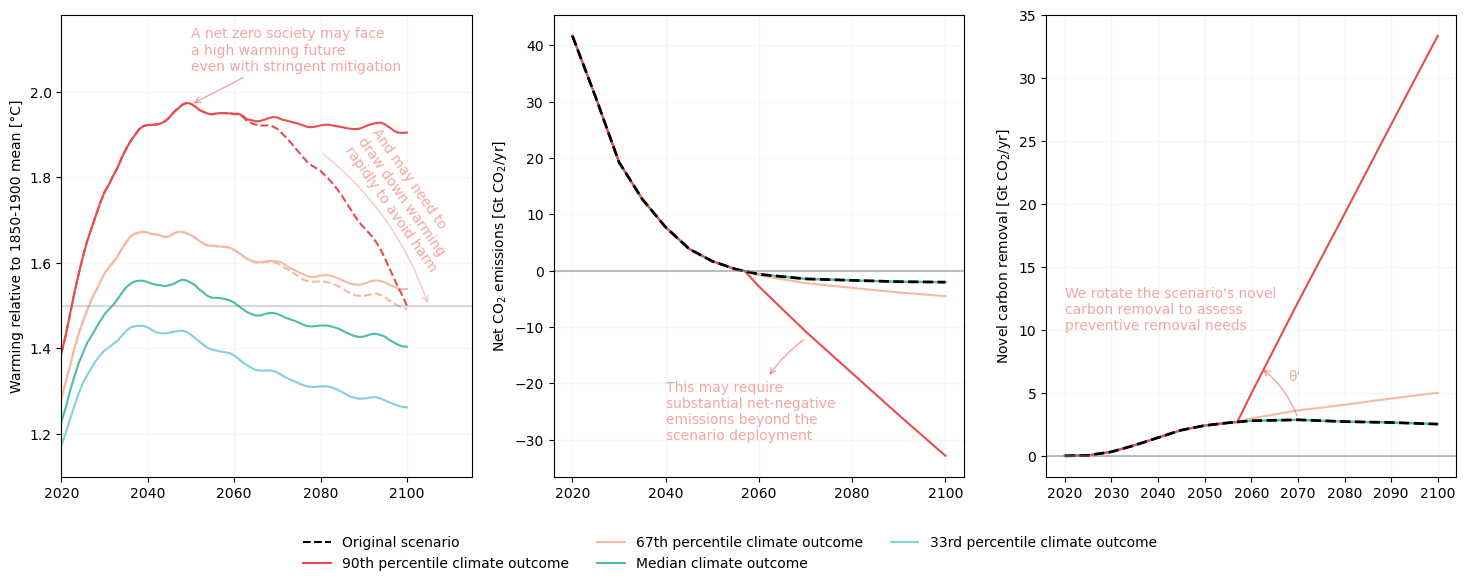

In [29]:
fig, ax = plt.subplot_mosaic(
    mosaic=[
        ['a', 'b', 'c']
    ],
    figsize=(18, 6)
)

# Panel a: Plot the temperatures
color_mapping_quantiles = {
    'p33':'#83d0e2',
    'p50':'#4dbdab',
    'p67':'#f7b9a6',
    'p90':'#e74d4d'
}

for q in color_mapping_quantiles.keys():
    original_temp = original_temp_quantiles.filter(
        variable=f'Surface Air Temperature Change [{q}]',
        year=range(2020,2101)
    )
    original_temp.plot(
        ax=ax['a'],
        color=color_mapping_quantiles[q]
    )
    if q in ['p67', 'p90']:
        proc_temp = proc_temp_quantiles.filter(
            variable=f'Surface Air Temperature Change [{q}]',
            year=range(2020,2101)
        )
        proc_temp.plot(
            ax=ax['a'],
            color=color_mapping_quantiles[q],
            linestyle='dashed'
        )
ax['a'].axhline(1.5, color='grey', alpha=0.3)
ax['a'].get_legend().remove()
ax['a'].set_title('')
ax['a'].set_xlabel('')
ax['a'].set_ylabel('Warming relative to 1850-1900 mean [°C]')
ax['a'].annotate(
    'A net zero society may face\na high warming future\neven with stringent mitigation',
    xy=(2050, 1.97),
    xytext=(2050, 2.05),
    arrowprops=dict(color='#e74d4d', arrowstyle='->', alpha=0.5),
    color='#e74d4d',
    alpha=0.5
)
ax['a'].annotate(
    '',
    xy=(2105, 1.5),
    xytext=(2080, 1.86),
    arrowprops=dict(color='#e74d4d', arrowstyle='->', alpha=0.3, connectionstyle='arc3,rad=-0.15'),
)
ax['a'].set_ylim(1.1, 2.18)
ax['a'].grid(alpha=0.1)
ax['a'].annotate(
    'And may need to\ndraw down warming\nrapidly to avoid harm',
    xy=(2085, 1.58),
    xytext=(2085, 1.58),
    color='#e74d4d',
    rotation=305,
    alpha=0.5
)
ax['a'].set_xlim(2020, 2115)
# panel b - plot out the CO2 emission trajectories
for q in color_mapping_quantiles.keys():
    compiled_emissions.filter(
        variable=f'AR6 climate diagnostics|Infilled|Emissions|CO2 [{q}]',
        year=range(2020,2101)
    ).plot(
        ax=ax['b'],
        color=color_mapping_quantiles[q]
    )
compiled_emissions.filter(
    variable='AR6 climate diagnostics|Infilled|Emissions|CO2',
    year=range(2020,2101)
).plot(ax=ax['b'], color='black', linestyle='dashed', lw=2)
ax['b'].set_title('')
ax['b'].set_xlabel('')
ax['b'].set_ylabel('Net CO$_2$ emissions [Gt CO$_2$/yr]')
ax['b'].grid(alpha=0.1)
ax['b'].axhline(0, color='grey', alpha=0.5)
ax['b'].annotate(
    'This may require\nsubstantial net-negative\nemissions beyond the\nscenario deployment',
    xy=(2070, -12),
    xytext=(2040, -30),
    arrowprops=dict(color='#e74d4d', arrowstyle='<-', alpha=0.5, connectionstyle='arc3,rad=-0.15'),
    alpha=0.5,
    color='#e74d4d'
)
ax['b'].set_xticks([2020, 2040, 2060, 2080, 2100])
ax['b'].get_legend().remove()
# panel c
for q in color_mapping_quantiles.keys():
    compiled_emissions.filter(
        variable=f'Carbon Dioxide Removal|Novel [{q}]',
        year=range(2020,2101)
    ).plot(
        ax=ax['c'],
        color=color_mapping_quantiles[q]
    )
compiled_emissions.filter(
    variable='Carbon Dioxide Removal|Novel',
    year=range(2020,2101)
).plot(ax=ax['c'], color='black', linestyle='dashed', lw=2)
ax['c'].set_title('')
ax['c'].set_xlabel('')
ax['c'].set_ylabel('Novel carbon removal [Gt CO$_2$/yr]')
ax['c'].grid(alpha=0.1)
ax['c'].axhline(0, color='grey', alpha=0.5)
ax['c'].annotate(
    '',
    xy=(2070,3),
    xytext=(2062, 7),
    arrowprops=dict(color='#e74d4d', arrowstyle='<-', alpha=0.5, connectionstyle='arc3,rad=-0.15'),
    alpha=0.5
)
ax['c'].annotate(
    "θ'",
    xy=(2068,6),
    xytext=(2068, 6),
    alpha=0.5,
    color='#e74d4d'
)
ax['c'].annotate(
    "We rotate the scenario's novel\ncarbon removal to assess \npreventive removal needs",
    xy=(2020, 10),
    color='#e74d4d',
    alpha=0.5
)
ax['c'].get_legend().remove()
# Make the legend
legend_handles = [
    Line2D([0], [0], color='black', linestyle='dashed', label='Original scenario'),
    Line2D([0], [0], color='#e74d4d', label='90th percentile climate outcome'),
    Line2D([0], [0], color='#f7b9a6', label='67th percentile climate outcome'),
    Line2D([0], [0], color='#4dbdab', label='Median climate outcome'),
    Line2D([0], [0], color='#83d0e2', label='33rd percentile climate outcome')
]
ax['b'].legend(
    handles=legend_handles,
    bbox_to_anchor=(1.5, -0.1),
    ncol=3,
    frameon=False
)

In [30]:
fig.savefig(
    Path('../results/Figure1.png'),
    dpi=600,
    bbox_inches='tight'
)